### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import gc
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed

### Data and Parameters

- Here the fragment and its associated masks

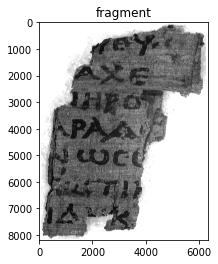

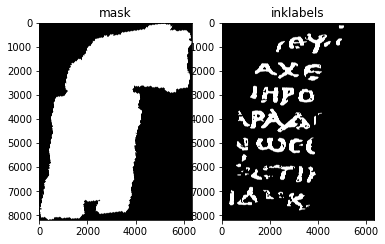

In [2]:
PREFIX = '../vesuvius-challenge-ink-detection/train/1/'
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
TRAINING_STEPS = 30000
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.title('fragment')
plt.imshow(Image.open(PREFIX+"ir.png"), cmap="gray")
plt.show()

mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels")
ax2.imshow(label.cpu(), cmap='gray')
plt.show()


- Here some of the slices of the corresponding fragment along the z axis

100%|████████████████████████████████████████████| 10/10 [00:02<00:00,  4.84it/s]


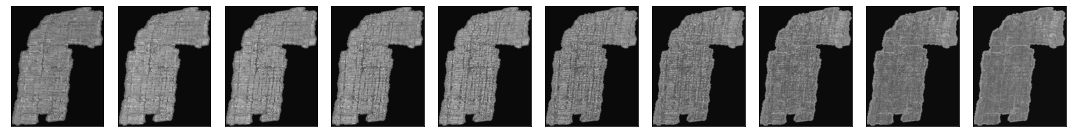

In [3]:
# Load the 3d x-ray scan, one slice at a time
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
  ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
  ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()


- Create a dataset of subvolumes

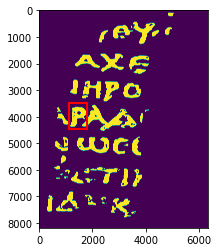

In [4]:
rect = (1100, 3500, 700, 950)
fig, ax = plt.subplots()
ax.imshow(label.cpu())
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [5]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel


### Train a simple conv3D based model

In [6]:
model = nn.Sequential(
    nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Flatten(start_dim=1),
    nn.LazyLinear(128), nn.ReLU(),
    nn.LazyLinear(1), nn.Sigmoid()
).to(DEVICE)

/home/jean/.local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
print("Generating pixel lists...")
# Split our dataset into train and val. The pixels inside the rect are the 
# val set, and the pixels outside the rect are the train set.
pixels_inside_rect = []
pixels_outside_rect = []
for pixel in zip(*np.where(mask == 1)):
    if pixel[1] < BUFFER or pixel[1] >= mask.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= mask.shape[0]-BUFFER:
        continue # Too close to the edge
    if pixel[1] >= rect[0] and pixel[1] <= rect[0]+rect[2] and pixel[0] >= rect[1] and pixel[0] <= rect[1]+rect[3]:
        pixels_inside_rect.append(pixel)
    else:
        pixels_outside_rect.append(pixel)

print("Training...")
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
model.train()
# running_loss = 0.0
for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS):
    if i >= TRAINING_STEPS:
        break
    optimizer.zero_grad()
    outputs = model(subvolumes.to(DEVICE))
    loss = criterion(outputs, inklabels.to(DEVICE))
    loss.backward()
    optimizer.step()
    scheduler.step()

Generating pixel lists...
Training...


100%|██████████████████████████████████████| 30000/30000 [10:24<00:00, 48.00it/s]


### Inference

- Eval the model on the square we spare from he training data

100%|█████████████████████████████████████| 20833/20833 [01:55<00:00, 179.98it/s]


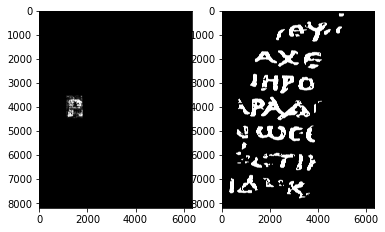

In [8]:
eval_dataset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
output = torch.zeros_like(label).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        for j, value in enumerate(model(subvolumes.to(DEVICE))):
            output[pixels_inside_rect[i*BATCH_SIZE+j]] = value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

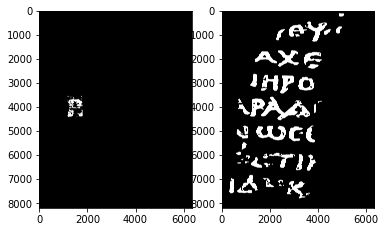

In [9]:
THRESHOLD = 0.4
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.gt(THRESHOLD).cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()